# Semi-Supervised Architope (Chaotic Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters
In Grid_Enhanced_NetworkGrid_Enhanced_Network.py file

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 9

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid - here is set the Option_Function
exec(open('Grid_Enhanced_Network.py').read()) 
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Chaos_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
    print("Test Data size: ",X_test.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
ks input data             0         1         2         3         4         5         6  \
0    0.125730 -0.132105  0.640423  0.104900 -0.535669  0.361595  1.304000   
1    0.216882  0.226767  0.206371  0.167188  0.095333  0.007688 -0.103964   
2    0.162985  0.149990  0.112828  0.065765 -0.003181 -0.076505 -0.163321   
3    0.114432  0.092607  0.051743  0.006617 -0.054806 -0.115655 -0.186224   
4    0.079127  0.052647  0.010571 -0.032159 -0.087764 -0.139907 -0.199704   
..        ...       ...       ...       ...       ...       ...       ...   
993  7.059567  5.393529  3.464303  1.401718 -0.676549 -2.624797 -4.340786   
994  7.501198  5.928769  4.059124  2.014938 -0.088556 -2.102837 -3.918068   
995  7.894172  6.419470  4.617361  2.602546  0.486503 -1.580957 -3.483852   
996  8.239988  6.865526  5.137275  3.161374  1.044443 -1.063830 -3.042747   
997  8.540795  7.267648  5.618023  3.689128  1.581829 -0.555574 -2.599042   

        

In [6]:
print(Option_Function)

ks


### Set Seed

In [7]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [8]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [9]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    # note this operation:',distance_matrix(X_train_in_shuffled,X_train_in_shuffled).shape)
    print('size of Data driven radius:',Delta_X.shape)
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print('pool train loop percentage:',(N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                #y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
                y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Apply Random Partitioner to the given Dataset

In [10]:
import time
partitioning_time_begin = time.time()

In [11]:
if Option_Function == 'SnP':
    q_in_auto = .8
    Min_data_size_percentage_auto = .1
    min_size_part = 100
else:
    if Option_Function == 'crypto':
        q_in_auto = .99
        Min_data_size_percentage_auto = .3
        min_size_part = 100
    if Option_Function == 'Motivational_Example':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 10
        # Partition Based on Y
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
    if Option_Function == 'ks':
        q_in_auto = .5
        Min_data_size_percentage_auto = .5
        min_size_part = 30
    else:
        q_in_auto = .5
        Min_data_size_percentage_auto = .3
        min_size_part = 100

In [12]:
# Initialize Number of Parts currently generated
N_parts_generated = 0

# Generate Partition (with option to regenerate if only 1 part is randomly produced)
while N_parts_generated < 2:
    # Generate Parts
    X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                      q_in=q_in_auto, 
                                                                      X_train_in=X_train, 
                                                                      y_train_in=data_y, 
                                                                      CV_folds_failsafe=CV_folds,
                                                                      min_size = min_size_part)
    
    # Update Number of Parts
    N_parts_generated = len(X_parts_list)
    # Shuffle hyperparameters
    Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
    q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1
    
    # Update User
    print('The_parts_listhe number of parts in the input are: ' + str(len(X_parts_list))+'.')
    print('X_parts_list:', X_parts_list)
    print('The_parts_listhe number of parts in the output are: ' + str(len(y_parts_list))+'.')
    print('y_parts_list:', y_parts_list)
    
# Trash removal (removes empty parts)
X_parts_list = list(filter(([]).__ne__, X_parts_list))
y_parts_list = list(filter(([]).__ne__, y_parts_list))
    
    
# ICML Rebuttle Deadline = Coersion!
if Option_Function == 'Motivational_Example':
    # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
    holder_temp = data_y
    data_y = X_train
    X_train = holder_temp
    holder_temp = y_parts_list
    y_parts_list = X_parts_list
    X_parts_list = holder_temp

size of Data driven radius: (898,)
pool train loop percentage: 0.9220489977728286
pool train loop percentage: 0.8942093541202673
pool train loop percentage: 0.8752783964365256
pool train loop percentage: 0.856347438752784
pool train loop percentage: 0.8396436525612472
pool train loop percentage: 0.8251670378619154
pool train loop percentage: 0.811804008908686
pool train loop percentage: 0.7984409799554566
pool train loop percentage: 0.7850779510022272
pool train loop percentage: 0.7739420935412027
pool train loop percentage: 0.7628062360801782
pool train loop percentage: 0.7494432071269488
pool train loop percentage: 0.7371937639198218
pool train loop percentage: 0.7249443207126949
pool train loop percentage: 0.7115812917594655
pool train loop percentage: 0.6993318485523385
pool train loop percentage: 0.6870824053452116
pool train loop percentage: 0.6714922048997772
pool train loop percentage: 0.6570155902004454
pool train loop percentage: 0.643652561247216
pool train loop percentage: 

In [13]:
#Iteration_Length = len(X_parts_list)
#N_modify = []
#for jj in range(Iteration_Length):
 #   N_modify = np.append(N_modify,(len(X_parts_list[jj])))
    
#print(N_modify)

In [14]:
partitioning_time = time.time() - partitioning_time_begin

In [15]:
print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

The_parts_listhe number of parts are: 2.


#### Building Training Predictions on each part (each part represent a different manifold) and Train the Deep Classifier
- Train locally (on each "naive part" and after on each "trained part")
- Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
- Generate predictions on all of testing-set (will be selected between later using classifier)

epochs for training interaction: 0
 
 
 
----------------------------------------------------
---------- Train each model on each part -----------
---------------------- DMD -------------------------
----------------------------------------------------
 
 
 
N_modify: [0.078125 0.921875]
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 0 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 70)
X2 shape: (2048, 70)


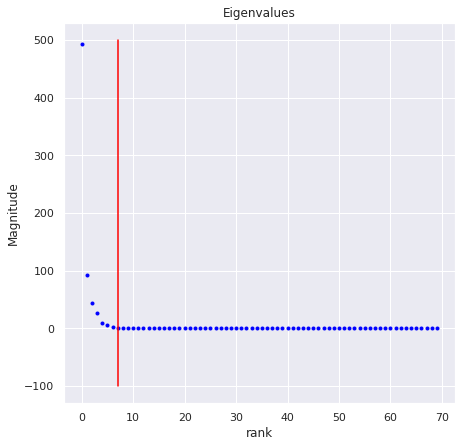

omega: [-555.72121914+0.j          -54.45498041+0.j
    6.56969573+6.53106508j    6.56969573-6.53106508j
    3.33294399+0.j            1.65112462+0.j
   -9.82993524+0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 826)
X2 shape: (2048, 826)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


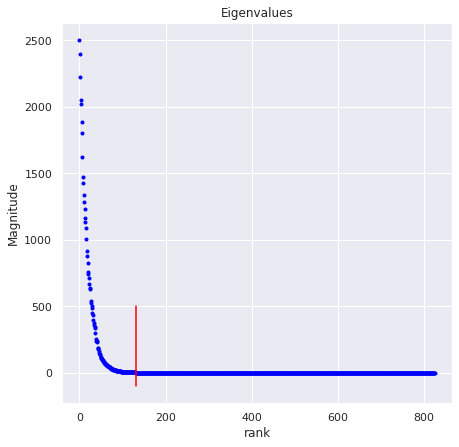

omega: [-6.37790390e-01+49.94597165j -6.37790390e-01-49.94597165j
 -5.83343497e-01+48.44768268j -5.83343497e-01-48.44768268j
 -7.04072406e-01+47.42699258j -7.04072406e-01-47.42699258j
 -6.89230829e-01+45.62031312j -6.89230829e-01-45.62031312j
 -5.77175355e-01+44.62535368j -5.77175355e-01-44.62535368j
 -3.41320484e-01+44.00497132j -3.41320484e-01-44.00497132j
 -2.48419879e-01+43.19289087j -2.48419879e-01-43.19289087j
 -1.63760076e+00+43.10061868j -1.63760076e+00-43.10061868j
  1.86715758e-02+41.67302395j  1.86715758e-02-41.67302395j
 -1.56815854e+00+40.85873638j -1.56815854e+00-40.85873638j
 -1.79137757e-01+40.60396097j -1.79137757e-01-40.60396097j
 -2.15935278e-02+39.83214926j -2.15935278e-02-39.83214926j
  5.07901964e-02+38.25662012j  5.07901964e-02-38.25662012j
 -3.80393628e-01+38.49997406j -3.80393628e-01-38.49997406j
  1.07778156e-01+37.40672496j  1.07778156e-01-37.40672496j
  3.62206846e-02+36.68513187j  3.62206846e-02-36.68513187j
  2.00280729e-02+35.83912176j  2.00280729e-02-35.

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.0923337936401367
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_inte

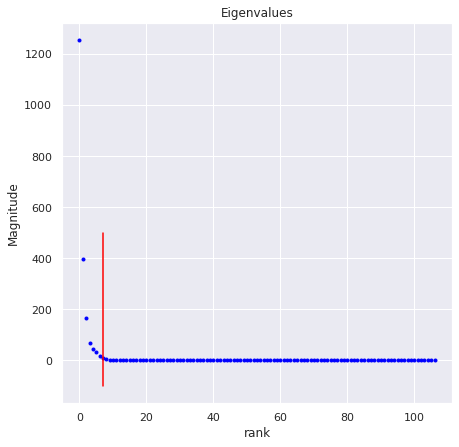

omega: [-354.22819288 +0.j            5.11586893+12.8841532j
    5.11586893-12.8841532j     3.81170054 +5.01513369j
    3.81170054 -5.01513369j    2.85874211 +0.j
   -1.16809742 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 793)
X2 shape: (2048, 793)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


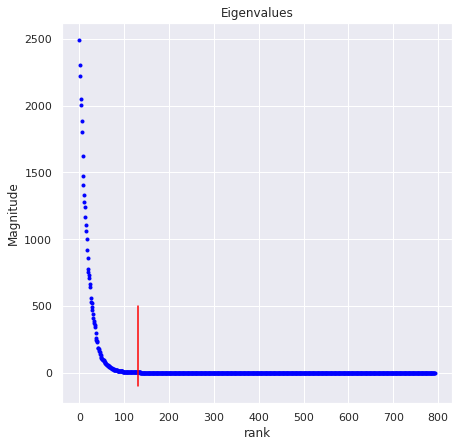

omega: [-9.46784103e-01+51.11731699j -9.46784103e-01-51.11731699j
 -8.97859173e-01+50.13675998j -8.97859173e-01-50.13675998j
 -4.64064319e-01+48.71558218j -4.64064319e-01-48.71558218j
 -8.19226294e-01+46.93292559j -8.19226294e-01-46.93292559j
 -6.34696313e-01+45.90283534j -6.34696313e-01-45.90283534j
 -9.95112479e-01+45.73019897j -9.95112479e-01-45.73019897j
 -2.67724588e-01+44.65885974j -2.67724588e-01-44.65885974j
 -6.56738726e-01+43.50107085j -6.56738726e-01-43.50107085j
 -1.23658815e-01+43.13191115j -1.23658815e-01-43.13191115j
 -1.03877244e+00+42.40464658j -1.03877244e+00-42.40464658j
 -6.84124666e-02+41.20440514j -6.84124666e-02-41.20440514j
 -2.28430496e+00+40.81712272j -2.28430496e+00-40.81712272j
 -1.27537200e-01+40.14157358j -1.27537200e-01-40.14157358j
 -2.50106545e-01+39.42843533j -2.50106545e-01-39.42843533j
 -2.85786402e-02+38.40639543j -2.85786402e-02-38.40639543j
 -6.67418962e-01+37.48425854j -6.67418962e-01-37.48425854j
  8.01306299e-02+37.33993445j  8.01306299e-02-37.

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.402780294418335
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integ

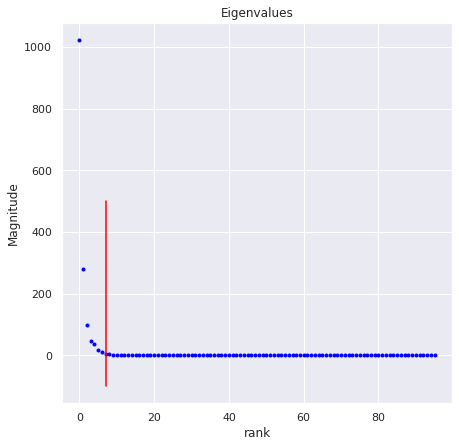

omega: [-418.48458697 +0.j            5.73212941+10.80530993j
    5.73212941-10.80530993j    3.51515951 +3.60272463j
    3.51515951 -3.60272463j    2.0183159  +0.j
  -13.63893933 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 802)
X2 shape: (2048, 802)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


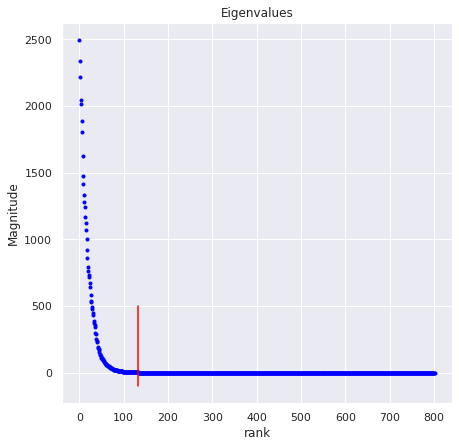

omega: [-9.34520909e-01+50.25167111j -9.34520909e-01-50.25167111j
 -7.01813572e-01+49.72265974j -7.01813572e-01-49.72265974j
 -6.23937775e-01+47.93108649j -6.23937775e-01-47.93108649j
 -1.28344013e+00+46.53872391j -1.28344013e+00-46.53872391j
 -4.84502857e-01+45.88635849j -4.84502857e-01-45.88635849j
 -4.04053524e-01+44.82833216j -4.04053524e-01-44.82833216j
 -5.18076544e-01+43.95588394j -5.18076544e-01-43.95588394j
 -4.51888062e-01+43.031578j   -4.51888062e-01-43.031578j
 -7.95806389e-01+42.80220613j -7.95806389e-01-42.80220613j
 -4.28995589e-01+41.62350267j -4.28995589e-01-41.62350267j
 -3.04153425e-01+41.15083711j -3.04153425e-01-41.15083711j
 -1.13348892e-01+40.22467713j -1.13348892e-01-40.22467713j
 -4.63020584e+00+38.30369831j -4.63020584e+00-38.30369831j
 -2.63547770e-01+39.23806866j -2.63547770e-01-39.23806866j
 -3.66236114e-02+38.58541457j -3.66236114e-02-38.58541457j
 -3.79632749e-02+37.53345498j -3.79632749e-02-37.53345498j
 -1.50164700e-01+37.00976544j -1.50164700e-01-37.00

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.203670024871826
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integ

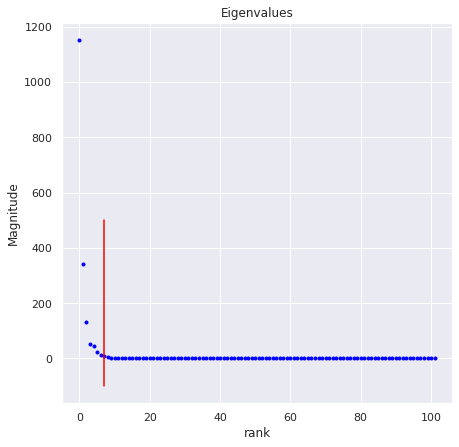

omega: [-379.50096227 +0.j            5.30471792+11.91908519j
    5.30471792-11.91908519j    3.77155562 +4.478133j
    3.77155562 -4.478133j      2.7584974  +0.j
   -4.99628648 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 795)
X2 shape: (2048, 795)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


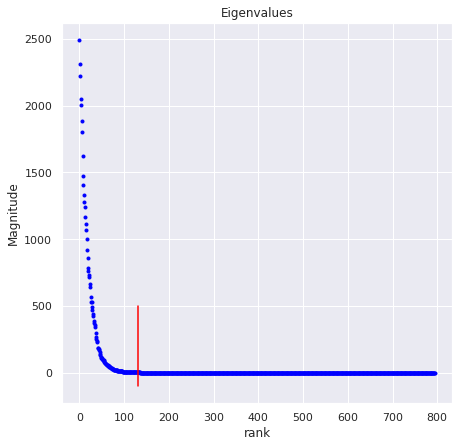

omega: [-9.60402732e-01+50.98406896j -9.60402732e-01-50.98406896j
 -9.22213103e-01+50.102245j   -9.22213103e-01-50.102245j
 -4.72153497e-01+48.71795816j -4.72153497e-01-48.71795816j
 -8.07059540e-01+46.7648175j  -8.07059540e-01-46.7648175j
 -6.58589496e-01+45.89085305j -6.58589496e-01-45.89085305j
 -9.46703748e-01+45.39874976j -9.46703748e-01-45.39874976j
 -2.70544085e-01+44.63716327j -2.70544085e-01-44.63716327j
 -2.35165211e-01+43.11562606j -2.35165211e-01-43.11562606j
 -7.12402000e-01+43.29899089j -7.12402000e-01-43.29899089j
 -8.98274175e-01+42.33361979j -8.98274175e-01-42.33361979j
 -2.58488087e+00+40.77704806j -2.58488087e+00-40.77704806j
 -6.72771833e-02+41.18929877j -6.72771833e-02-41.18929877j
 -1.01698607e-01+40.11945573j -1.01698607e-01-40.11945573j
 -2.03007194e-01+39.37285098j -2.03007194e-01-39.37285098j
 -2.95956156e-02+38.4009827j  -2.95956156e-02-38.4009827j
  7.62975196e-02+37.29663514j  7.62975196e-02-37.29663514j
 -4.31665508e-01+37.48199778j -4.31665508e-01-37.4819

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.140413522720337
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integ

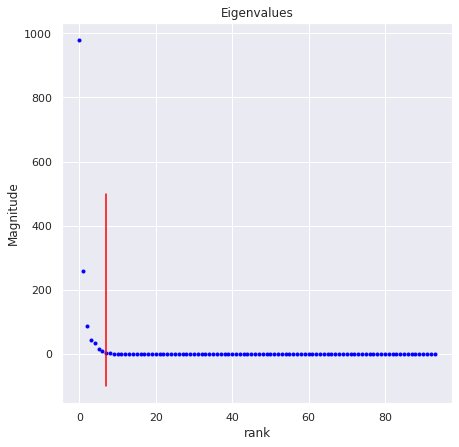

omega: [-430.03849319 +0.j            5.87348744+10.50389768j
    5.87348744-10.50389768j    3.53582226 +3.30201736j
    3.53582226 -3.30201736j    1.70578461 +0.j
  -16.69616195 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X1 shape: (2048, 804)
X2 shape: (2048, 804)


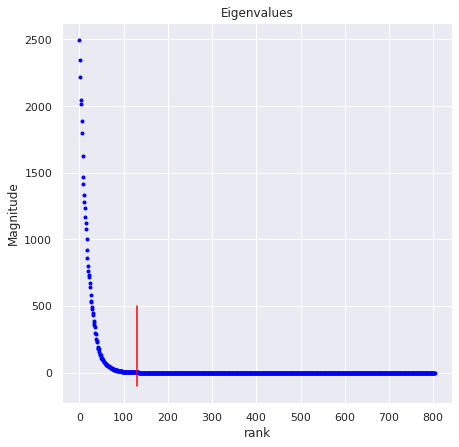

omega: [-9.53203670e-01+50.25761485j -9.53203670e-01-50.25761485j
 -5.62571733e-01+49.56832982j -5.62571733e-01-49.56832982j
 -6.39608085e-01+47.80735725j -6.39608085e-01-47.80735725j
 -1.27338365e+00+46.2107946j  -1.27338365e+00-46.2107946j
 -4.51836802e-01+45.89644845j -4.51836802e-01-45.89644845j
 -3.86010933e-01+44.81295585j -3.86010933e-01-44.81295585j
 -5.33844585e-01+43.90016242j -5.33844585e-01-43.90016242j
 -3.48191264e-01+42.94825737j -3.48191264e-01-42.94825737j
 -8.02682551e-01+42.54661026j -8.02682551e-01-42.54661026j
 -8.84433993e-02+41.36925961j -8.84433993e-02-41.36925961j
 -1.11855665e+00+40.74525283j -1.11855665e+00-40.74525283j
 -9.70167022e-02+40.29229914j -9.70167022e-02-40.29229914j
 -2.66733614e-01+39.31707124j -2.66733614e-01-39.31707124j
  4.08995970e-02+38.58085036j  4.08995970e-02-38.58085036j
 -5.84536256e-03+37.46143574j -5.84536256e-03-37.46143574j
 -3.07517281e-01+37.02217617j -3.07517281e-01-37.02217617j
 -4.84187511e+00+33.57072853j -4.84187511e+00-33.5

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.2523205280303955
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_inte

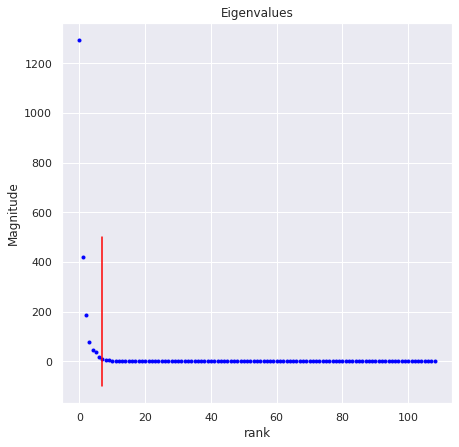

omega: [-3.46085981e+02 +0.j          5.03752808e+00+13.22374033j
  5.03752808e+00-13.22374033j  3.70192878e+00 +5.26334909j
  3.70192878e+00 -5.26334909j  2.68382193e+00 +0.j
 -1.38632730e-01 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 790)
X2 shape: (2048, 790)


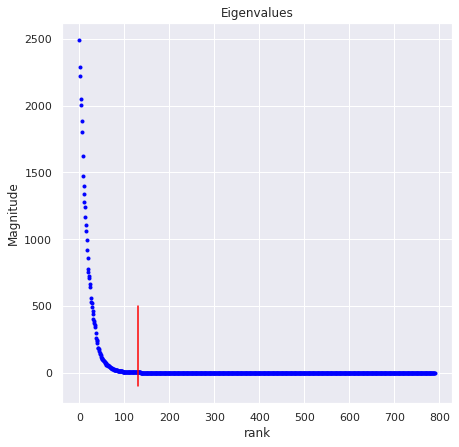

omega: [-0.59627177+51.96892163j -0.59627177-51.96892163j
 -1.06075914+50.57079636j -1.06075914-50.57079636j
 -0.746922  +48.91900348j -0.746922  -48.91900348j
 -0.48171706+48.46673279j -0.48171706-48.46673279j
 -0.80264421+46.56562151j -0.80264421-46.56562151j
 -0.80643892+45.85318266j -0.80643892-45.85318266j
 -0.82871843+44.8231687j  -0.82871843-44.8231687j
 -0.31771118+44.53513524j -0.31771118-44.53513524j
 -0.10012289+43.39663086j -0.10012289-43.39663086j
 -0.56487564+42.56138295j -0.56487564-42.56138295j
 -0.84560316+41.91584268j -0.84560316-41.91584268j
 -0.17922554+41.12052791j -0.17922554-41.12052791j
 -0.0942585 +40.1207554j  -0.0942585 -40.1207554j
 -4.61133485+36.74513383j -4.61133485-36.74513383j
 -0.10114132+39.20651577j -0.10114132-39.20651577j
 -0.1203994 +38.50854886j -0.1203994 -38.50854886j
 -0.21210529+37.6155601j  -0.21210529-37.6155601j
  0.09110183+37.01455074j  0.09110183-37.01455074j
 -0.11899872+36.03388372j -0.11899872-36.03388372j
  0.61908138+35.36732998j  

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.2363038063049316
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_inte

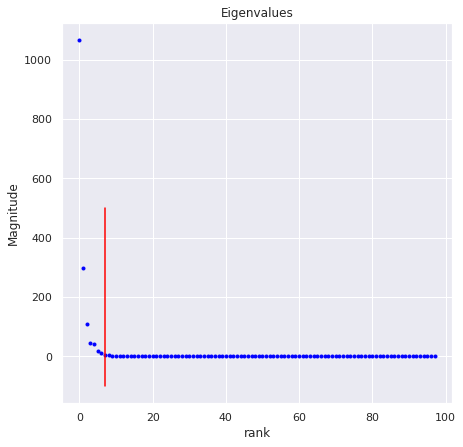

omega: [-405.44145643 +0.j            5.58996957+11.14130072j
    5.58996957-11.14130072j    3.5612466  +3.92200061j
    3.5612466  -3.92200061j    2.31300635 +0.j
  -10.40919547 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 800)
X2 shape: (2048, 800)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


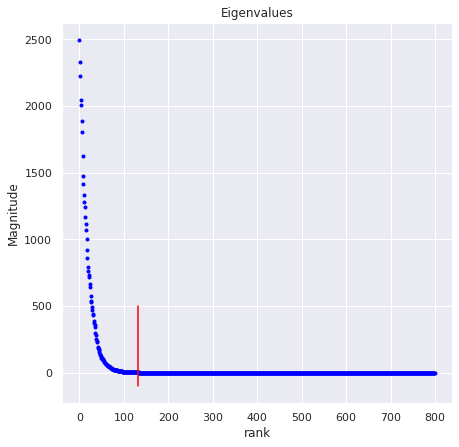

omega: [-9.13560349e-01+50.32186173j -9.13560349e-01-50.32186173j
 -8.95026557e-01+49.92899697j -8.95026557e-01-49.92899697j
 -6.16248829e-01+48.22582173j -6.16248829e-01-48.22582173j
 -1.22524217e+00+46.66621543j -1.22524217e+00-46.66621543j
 -5.43825944e-01+45.92779237j -5.43825944e-01-45.92779237j
 -5.57637086e-01+44.91202457j -5.57637086e-01-44.91202457j
 -4.35337703e-01+44.41530854j -4.35337703e-01-44.41530854j
 -5.03982950e-01+43.23621606j -5.03982950e-01-43.23621606j
 -5.43037414e-01+42.82345045j -5.43037414e-01-42.82345045j
 -5.91344511e-01+42.15384479j -5.91344511e-01-42.15384479j
 -1.07162106e-01+41.15026926j -1.07162106e-01-41.15026926j
 -3.74366582e+00+39.91642903j -3.74366582e+00-39.91642903j
 -8.59766776e-02+40.18346093j -8.59766776e-02-40.18346093j
 -1.98215712e-01+39.25483522j -1.98215712e-01-39.25483522j
 -6.28757001e-02+38.507471j   -6.28757001e-02-38.507471j
 -1.08465140e-01+37.5557033j  -1.08465140e-01-37.5557033j
 -7.20284924e-02+37.10804636j -7.20284924e-02-37.108

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.359006404876709
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integ

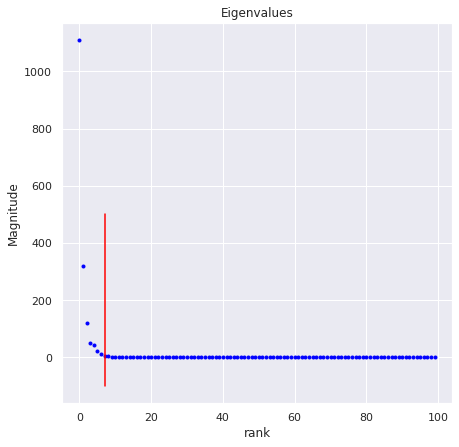

omega: [-392.01809581 +0.j            5.44170786+11.51700707j
    5.44170786-11.51700707j    3.66214634 +4.22416708j
    3.66214634 -4.22416708j    2.56718079 +0.j
   -7.41432155 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 798)
X2 shape: (2048, 798)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


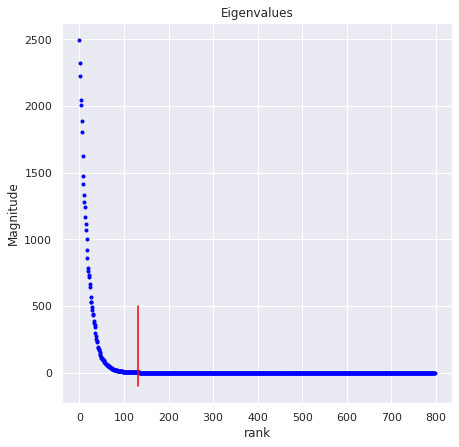

omega: [-9.52837244e-01+50.57587405j -9.52837244e-01-50.57587405j
 -9.67110413e-01+50.07284982j -9.67110413e-01-50.07284982j
 -5.43660112e-01+48.53487907j -5.43660112e-01-48.53487907j
 -1.04183717e+00+46.64137707j -1.04183717e+00-46.64137707j
 -6.35853395e-01+45.97631703j -6.35853395e-01-45.97631703j
 -7.17740840e-01+45.19622198j -7.17740840e-01-45.19622198j
 -2.95195923e-01+44.5861495j  -2.95195923e-01-44.5861495j
 -4.97485947e-01+43.20299677j -4.97485947e-01-43.20299677j
 -4.81910949e-01+42.99599677j -4.81910949e-01-42.99599677j
 -7.19059142e-01+42.30240483j -7.19059142e-01-42.30240483j
 -7.46643389e-02+41.17266944j -7.46643389e-02-41.17266944j
 -3.08108549e+00+40.40319885j -3.08108549e+00-40.40319885j
 -8.27767007e-02+40.14884916j -8.27767007e-02-40.14884916j
 -1.87378071e-01+39.29943634j -1.87378071e-01-39.29943634j
 -4.74809084e-02+38.44873287j -4.74809084e-02-38.44873287j
 -2.87194467e-02+37.21818104j -2.87194467e-02-37.21818104j
 -2.05079875e-01+37.49993523j -2.05079875e-01-37.4

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.0715394020080566
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_inte

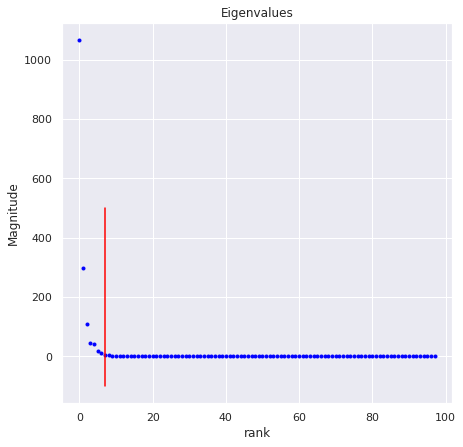

omega: [-405.44145643 +0.j            5.58996957+11.14130072j
    5.58996957-11.14130072j    3.5612466  +3.92200061j
    3.5612466  -3.92200061j    2.31300635 +0.j
  -10.40919547 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 800)
X2 shape: (2048, 800)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


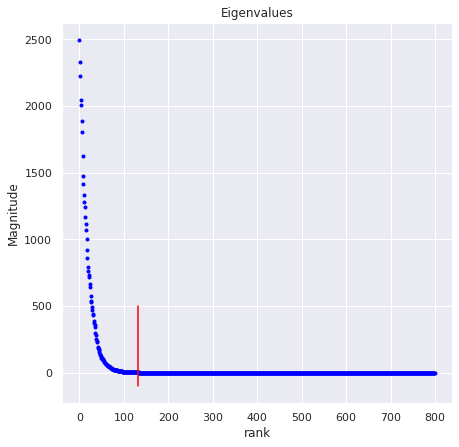

omega: [-9.13560349e-01+50.32186173j -9.13560349e-01-50.32186173j
 -8.95026557e-01+49.92899697j -8.95026557e-01-49.92899697j
 -6.16248829e-01+48.22582173j -6.16248829e-01-48.22582173j
 -1.22524217e+00+46.66621543j -1.22524217e+00-46.66621543j
 -5.43825944e-01+45.92779237j -5.43825944e-01-45.92779237j
 -5.57637086e-01+44.91202457j -5.57637086e-01-44.91202457j
 -4.35337703e-01+44.41530854j -4.35337703e-01-44.41530854j
 -5.03982950e-01+43.23621606j -5.03982950e-01-43.23621606j
 -5.43037414e-01+42.82345045j -5.43037414e-01-42.82345045j
 -5.91344511e-01+42.15384479j -5.91344511e-01-42.15384479j
 -1.07162106e-01+41.15026926j -1.07162106e-01-41.15026926j
 -3.74366582e+00+39.91642903j -3.74366582e+00-39.91642903j
 -8.59766776e-02+40.18346093j -8.59766776e-02-40.18346093j
 -1.98215712e-01+39.25483522j -1.98215712e-01-39.25483522j
 -6.28757001e-02+38.507471j   -6.28757001e-02-38.507471j
 -1.08465140e-01+37.5557033j  -1.08465140e-01-37.5557033j
 -7.20284924e-02+37.10804636j -7.20284924e-02-37.108

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.1779944896698
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integer

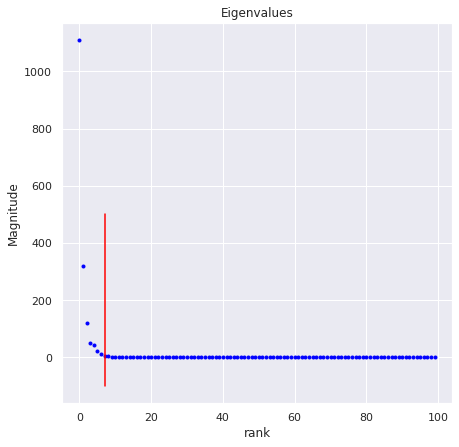

omega: [-392.01809581 +0.j            5.44170786+11.51700707j
    5.44170786-11.51700707j    3.66214634 +4.22416708j
    3.66214634 -4.22416708j    2.56718079 +0.j
   -7.41432155 +0.j        ]
Phi shape: (2048, 7)
X_train: (898, 2048)
x1: [[ 0.12573022 -0.13210486  0.64042265 ... -0.54586607  0.18658386
   0.30767502]]
x1_test: [[4.7611613  6.0093655  7.21145328 ... 1.01592348 2.25566461 3.50973951]]
X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
training_quality shape: (898, 2048)
param_grid_Vanilla_Nets - input dim: [2048]
param_grid_Vanilla_Nets - output dim: [2048]
Status: Current part: 1 out of : 2 parts.
Heights to iterate over: [100]
X1 shape: (2048, 798)
X2 shape: (2048, 798)


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


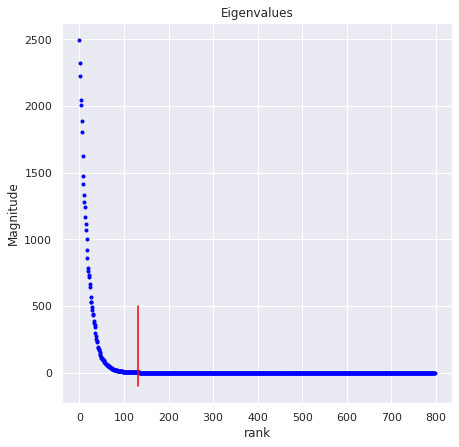

omega: [-9.52837244e-01+50.57587405j -9.52837244e-01-50.57587405j
 -9.67110413e-01+50.07284982j -9.67110413e-01-50.07284982j
 -5.43660112e-01+48.53487907j -5.43660112e-01-48.53487907j
 -1.04183717e+00+46.64137707j -1.04183717e+00-46.64137707j
 -6.35853395e-01+45.97631703j -6.35853395e-01-45.97631703j
 -7.17740840e-01+45.19622198j -7.17740840e-01-45.19622198j
 -2.95195923e-01+44.5861495j  -2.95195923e-01-44.5861495j
 -4.97485947e-01+43.20299677j -4.97485947e-01-43.20299677j
 -4.81910949e-01+42.99599677j -4.81910949e-01-42.99599677j
 -7.19059142e-01+42.30240483j -7.19059142e-01-42.30240483j
 -7.46643389e-02+41.17266944j -7.46643389e-02-41.17266944j
 -3.08108549e+00+40.40319885j -3.08108549e+00-40.40319885j
 -8.27767007e-02+40.14884916j -8.27767007e-02-40.14884916j
 -1.87378071e-01+39.29943634j -1.87378071e-01-39.29943634j
 -4.74809084e-02+38.44873287j -4.74809084e-02-38.44873287j
 -2.87194467e-02+37.21818104j -2.87194467e-02-37.21818104j
 -2.05079875e-01+37.49993523j -2.05079875e-01-37.4

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:190: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:191: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


X_dmd shape: (2048, 898)
y_train shape: (898, 2048)
y_hat_train_full_loop shape: (898, 2048)
y_test shape: (100, 2048)
y_hat_test_full_loop shape: (100, 2048)
y_hat_train_loop shape: (898, 2048)
predictions_train shape: (898, 2048, 2)
y_hat_test_loop shape: (100, 2048)
predictions_test shape: (100, 2048, 2)
y_hat_long_pred_loop shape: (1796, 2048)
predictions_long_pred shape: (1796, 2048, 2)
prediction_errors shape: (898, 2048)
training_quality shape: (898, 2048, 2)
 
 
 
----------------------------------------------------
Feature Generation (Learning Phase): Score Generated
----------------------------------------------------
 
 
 
Time-Elapsed Training on Each Part: 2.038076162338257
 
 
 
----------------------------------------------------
---------------- Train Classifier ------------------
---------------- Deep  Classifier ------------------
----------------------------------------------------
 
 
 
partition_labels_training_integers shape: (898,)
partition_labels_training_integ

In [16]:
epochs_training_interaction = 10
for ntrain_interaction in range(epochs_training_interaction):
    print('epochs for training interaction:',ntrain_interaction)
    #############################################################
    #############################################################
    ############--- Train each FFNN on each part ---#############
    #############################################################
    #############################################################
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('---------- Train each model on each part -----------')
    print('---------------------- DMD -------------------------')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    # Time-Elapse (Start) for Training on Each Part
    Architope_partition_training_begin = time.time()
    # Initialize running max for Parallel time
    Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
    # Initialize N_parameter counter for Architope
    N_params_Architope = 0
    #
    tf.compat.v1.disable_eager_execution()
    # Silly Coercsion for ICML rebuttle deadline timeline
    if Option_Function == 'Motivational_Example':
        Iteration_Length = len(X_parts_list) -1
    else:
        Iteration_Length = len(X_parts_list)
    #
    N_modify0 = []
    for kk in range(Iteration_Length):
        N_modify0 = np.append(N_modify0,(len(X_parts_list[kk])))
    #
    N_modify_tot = sum(N_modify0)
    #
    N_modify = []
    for jj in range(Iteration_Length):
        N_modify = np.append(N_modify,(len(X_parts_list[jj])/N_modify_tot))
    #
    print('N_modify:',N_modify)
    #
    # Train each part!
    for current_part in range(Iteration_Length):
        #==============#
        # Timer(begin) #
        #==============#
        current_part_training_time_for_parallel_begin = time.time()
        #
        Iteration_Length = len(X_parts_list)
        #
        #    
        # Initializations #
        #-----------------#
        # Reload Grid
        exec(open('Grid_Enhanced_Network.py').read())
        # Modify heights according to optimal (data-driven) rule (with threshold)
        ## current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
        ## print('N_ratios',N_ratios,'Iteration_Length',Iteration_Length)
        ##################################################################################################
        ##################################################################################################
        ##################################################################################################
        # Modify heights of the ANN in order to make it more interpretable for our approach
        current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height']))#*N_modify[current_part])
        ##################################################################################################
        ##################################################################################################
        current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
        current_height = np.maximum(current_height,current_height_threshold)
        current_height = current_height.astype(int).tolist()
        # current_height = X_parts_list.shape[curerent_part,row]
        param_grid_Vanilla_Nets['height'] = current_height
        # Automatically Fix Input Dimension
        param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
        param_grid_Vanilla_Nets['output_dim'] = [X_train.shape[1]]
        print('param_grid_Vanilla_Nets - input dim:',param_grid_Vanilla_Nets['input_dim'])
        print('param_grid_Vanilla_Nets - output dim:',param_grid_Vanilla_Nets['output_dim'])
        #
        # Update User #
        #-------------#
        print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
        print('Heights to iterate over: '+str(current_height))
        #
        # Generate Prediction(s) on current Part #
        #----------------------------------------#
        # Failsafe (number of data-points)
        CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
        # Train Network
        #y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                          #n_jobs = n_jobs,
                                                                                          #n_iter = n_iter, 
                                                                                          #param_grid_in = param_grid_Vanilla_Nets, 
                                                                                          #X_train= X_parts_list[current_part], 
                                                                                          #y_train=y_parts_list[current_part],
                                                                                          #X_test_partial=X_train,
                                                                                          #X_test=X_test #NOCV=True)
        # DMD (Dynamic Mode Decomposition)
        # Here we apply the DMD algorithm
        ######################################################
        ######################################################
        ######################################################
        # get two views of the data matrix offset by one time step
        #X1 = np.matrix(X[:, 0:-2]) #augmented input data state space
        #X2 = np.matrix(X[:, 1:-1]) #augmented output data state space
        X1 = np.matrix(X_parts_list[current_part]).T #augmented input data state space
        X2 = np.matrix(y_parts_list[current_part]).T #augmented output data state space
        X1_test = np.matrix(X_test).T #augmented input data state space
        print('X1 shape:',X1.shape)
        print('X2 shape:',X2.shape)
        # Run SVD on the data view of X1
        U,s,Vh = np.linalg.svd(X1)
        V = Vh.conj().T
        S = np.matrix(np.diag(s))
        ##########################################
        ##########################################
        fig = plt.figure(figsize=(7,7))
        # Creating subplot/axes
        ax = fig.add_subplot(111)
        
        # Setting axes/plot title
        ax.set_title('Eigenvalues')
        
        # Setting X-axis and Y-axis limits
        #ax.set_xlim([0.5, 4.5])
        #ax.set_ylim([-3, 7])
        if current_part == 0:
            r = 7 #rank truncation
        else:
            r = 131 #rank truncation
        
        ax.plot(s,'.', color='blue')
        ax.plot([r, r], [-100, 500], color='red')
        
        # Setting X-axis and Y-axis labels
        ax.set_ylabel('Magnitude')
        ax.set_xlabel('rank')
        
        # Showing the plot
        plt.show()
        ##########################################
        ##########################################
        #
        Ur = U[:, 0:r]
        Sr = S[0:r, 0:r]
        Vr = V[:, 0:r]
        #
        # Calculate Atilde
        #python and numpy do not offer the fancy '/' command as MatLab
        #does. Instead we solve for Atilde using one of the
        #following approaches.
        # Approach 1: works because Sr is square
        Atilde = Ur.conj().T*X2*Vr*np.linalg.inv(Sr)
        ########### print('Atilde:',Atilde)
        # Approach 2: more general, use least squares to solve aT xT = bT, where:
        #   xT = Atilde
        #   aT = Sr
        #   bT = Ur.conj().T*X2*Vr
        #__b = Ur.conj().T*X2*Vr #uncomment this line to use Approach 2
        #__a = Sr #uncomment this line to use Approach 2
        #__r = np.linalg.lstsq(__a.T, __b.T) #uncomment this line to use Approach 2
        #__x = __r[0].T #uncomment this line to use Approach 2
        #Atilde = __x #uncomment this line to use Approach 2
        #print('Atilde:',Atilde) #uncomment this line to use Approach 2
        #
        # Compute DMD Spectra
        lamb, W = np.linalg.eig(Atilde)
        dt = 0.01 # check always that this is the delta t used to generate data
        omega = np.log(lamb)/dt
        print('omega:',omega)
        #
        # Compute DMD solution
        # Solve for Phi. Again, the inverse method works because Sr is square.
        Phi = X2*Vr*np.linalg.inv(Sr)*W #Compute DMD modes
        print('Phi shape:',Phi.shape)
        print('X_train:', X_train.shape)
        if current_part==0:
            omega_manifold1 = np.imag(omega)
            lambda_manifold1 = np.real(omega)
            Phi_manifold1 = Phi
        elif current_part==1:
            omega_manifold2 = np.imag(omega)
            lambda_manifold2 = np.real(omega)
            Phi_manifold2 = Phi
        #
        x1 = np.matrix(X1[:,0]).T
        x1_test = np.matrix(X1_test[:,0]).T
        print('x1:',x1)
        print('x1_test:',x1_test)
        b, resid, rank, s = np.linalg.lstsq(Phi, x1.T)
        b_test, resid_test, rank_test, s_test = np.linalg.lstsq(Phi, x1_test.T)
        #print('b shape:',b.shape)
        #print('omega shape:', omega.shape)
        ### train ###
        time_dynamics = None
        for i in range(X_train.shape[0]):
            v = np.array(b)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
            if time_dynamics is None:
                time_dynamics = v
            else:
                time_dynamics = np.vstack((time_dynamics, v))
        #############
        ### test ###
        time_dynamics_test = None
        for i in range(X_test.shape[0]):
            v_test = np.array(b_test)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
            if time_dynamics_test is None:
                time_dynamics_test = v_test
            else:
                time_dynamics_test = np.vstack((time_dynamics_test, v_test))
        #############
        ### long term prediction ###
        time_dynamics_long_pred = None
        for i in range(X_train.shape[0]+X_train.shape[0]):
            v_long_pred = np.array(b)[:,0]*np.exp( np.array(omega)*(i+1)*dt)
            if time_dynamics_long_pred is None:
                time_dynamics_long_pred = v_long_pred
            else:
                time_dynamics_long_pred = np.vstack((time_dynamics_long_pred, v_long_pred))
        #############
        #print('time_dynamics shape:', time_dynamics.shape)
        X_dmd = np.dot( np.array(Phi), time_dynamics.T) #training reconstruction
        X_dmd_test = np.dot( np.array(Phi), time_dynamics_test.T) #test reconstruction
        X_dmd_long_pred = np.dot( np.array(Phi), time_dynamics_long_pred.T) #training reconstruction + future prediction (test)
        print('X_dmd shape:',X_dmd.shape)
        y_hat_train_full_loop = X_dmd
        y_hat_test_full_loop = X_dmd_test
        y_hat_long_pred_full_loop = X_dmd_long_pred
        #
        #
        #
        #put shape formats in order
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        #y_hat_train_full_loop.shape = (y_hat_train_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_train_full_loop = y_hat_train_full_loop.T
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        #y_hat_test_full_loop.shape = (y_hat_test_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_test_full_loop = y_hat_test_full_loop.T
        y_hat_long_pred_full_loop = y_hat_long_pred_full_loop.T
        print('y_train shape:',y_train.shape)
        print('y_hat_train_full_loop shape:',y_hat_train_full_loop.shape)
        print('y_test shape:',y_test.shape)
        print('y_hat_test_full_loop shape:',y_hat_test_full_loop.shape)
        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
            print('training_quality shape:',training_quality.shape)
            #training_quality = training_quality.reshape(training_quality.shape[0],1)
            #print('training_quality shape after reshape:',training_quality.shape)
            #
            # Save Predictions
            predictions_train = y_hat_train_full_loop
            #predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
            predictions_test = y_hat_test_full_loop
            #predictions_test = predictions_test.reshape(predictions_test.shape[0],1)
            #long term prediction
            predictions_long_pred = y_hat_long_pred_full_loop
            #
            #        
        ## If not first prediction we append to already initialized dataframes
        else:
            # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],predictions_train.shape[1])
            print('y_hat_train_loop shape:',y_hat_train_loop.shape)
            predictions_train = np.dstack([predictions_train,y_hat_train_loop]) # stack along a new axis in last axis of the result
            print('predictions_train shape:',predictions_train.shape)
            y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],predictions_test.shape[1])
            print('y_hat_test_loop shape:',y_hat_test_loop.shape)
            predictions_test = np.dstack([predictions_test,y_hat_test_loop]) # stack along a new axis in last axis of the result
            print('predictions_test shape:',predictions_test.shape)
            #long term prediction
            y_hat_long_pred_loop = y_hat_long_pred_full_loop.reshape(predictions_long_pred.shape[0],predictions_long_pred.shape[1])
            print('y_hat_long_pred_loop shape:',y_hat_long_pred_loop.shape)
            predictions_long_pred = np.dstack([predictions_long_pred,y_hat_long_pred_loop]) # stack along a new axis in last axis of the result
            print('predictions_long_pred shape:',predictions_long_pred.shape)
            #
            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            print('prediction_errors shape:', prediction_errors.shape)
            training_quality = np.dstack([training_quality,prediction_errors.reshape(training_quality.shape[0],training_quality.shape[1])])
            print('training_quality shape:', training_quality.shape)
            #
        #============#
        # Timer(end) #
        #============#
        current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
        Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)
        #
        #============---===============#
        #
        # N_parameter Counter (Update) #
        #------------===---------------#
        N_params_Architope = N_params_Architope #+ N_params_Architope_loop
        #
    # Update User
    #-------------#
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('Feature Generation (Learning Phase): Score Generated')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    #
    # Time-Elapsed Training on Each Part
    Architope_partition_training = time.time() - Architope_partition_training_begin
    print('Time-Elapsed Training on Each Part:', Architope_partition_training)
    #
    #############################################################
    #############################################################
    ###################-- Train Classifier --####################
    #############################################################
    #############################################################
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('---------------- Train Classifier ------------------')
    print('---------------- Deep  Classifier ------------------')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')
    #Deep Classifier
    #Prepare Labels/Classes
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training_begin = time.time()
    # Initialize Classes Labels
    partition_labels_training_integers = np.argmin(np.sum(training_quality, axis=1),axis=-1)
    print('partition_labels_training_integers shape:', partition_labels_training_integers.shape)
    print('partition_labels_training_integers:', partition_labels_training_integers)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    #print('partition_labels_training shape:', partition_labels_training.shape)
    #print('partition_labels_training:', partition_labels_training)
    # Build Classes
    for part_column_i in range(1,(training_quality.shape[-1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    print('partition_labels_training shape:', partition_labels_training.shape)
    print('partition_labels_training:', partition_labels_training)
    # Convert to integers
    partition_labels_training = partition_labels_training+0
    partition_labels_training_new = np.zeros(predictions_train.shape)
    for jj in range(X_train.shape[1]):
        partition_labels_training_new[:,jj,:] = partition_labels_training
    #
    print('partition_labels_training_new shape:', partition_labels_training_new.shape)
    print('partition_labels_training_new:', partition_labels_training_new)
    #Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.
    print('Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary')
    # Re-Load Hyper-parameter Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Re-Load Helper Function(s)
    exec(open('Helper_Functions.py').read())
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    print('input_dim:', X_train.shape[1])
    param_grid_Deep_Classifier['output_dim'] = [partition_labels_training_new.shape[-1]]
    print('output_dim:', partition_labels_training_new.shape[-1])
    param_grid_Deep_Classifier['epochs'] = [int(np.maximum(round(param_grid_Deep_Classifier['epochs'][0]),min_epochs_classifier))]
    print('# epochs:',param_grid_Deep_Classifier['epochs'])
    print('---- Train Deep Classifier ----')
    # Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                             n_jobs = n_jobs, 
                                                                                                             n_iter =n_iter, 
                                                                                                             param_grid_in=param_grid_Deep_Classifier, 
                                                                                                             X_train = X_train.values, 
                                                                                                             y_train = partition_labels_training.values,
                                                                                                             X_test = X_test.values)
    # COMMENT: .values() is used to convert the Pandas Dataframes here, and not in the vanilla ffNNs, since the former is coded in Keras and the latter in tensorflow.
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin
    
    #GET BINARY CLASSES (DISCONTINUOUS UNIT)
    # Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    #### OLD: Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
    # Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    #### OLD: Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)
    
    #UPDATE to improve the interaction between the clustering and the regression problem
    # Train
    predicted_classes_train_update = np.zeros(predictions_train.shape)
    for jj in range(X_train.shape[1]):
        predicted_classes_train_update[:,jj,:] = predicted_classes_train
    # Test
    predicted_classes_test_update = np.zeros(predictions_test.shape)
    for jj in range(X_test.shape[1]):
        predicted_classes_test_update[:,jj,:] = predicted_classes_test
    
    
    print('predicted_classes_train shape:', predicted_classes_train.shape)
    print('predicted_classes_train_update shape:', predicted_classes_train_update.shape)
    print('predicted_classes_train_update:', predicted_classes_train_update)
    print('predictions_train shape :', predictions_train.shape)
    
    X_parts_list = list()
    y_parts_list = list()
    #X_parts_list = np.zeros(predictions_test.shape)
    #y_parts_list = np.zeros(predictions_test.shape)
    num_kkkk = predictions_train[1,1,:].shape
    num_kkkk = int(num_kkkk[0])
    print('number of manifolds:',num_kkkk)
    for kkkk in range(num_kkkk):
        X_manifold = []
        Elementindex = []
        elementindex = int(-1)
        while True:
            try:
                predicted_classes_train_update1 = []
                predicted_classes_train_update1 = predicted_classes_train_update[:,1,kkkk]
                predicted_classes_train_update1 = predicted_classes_train_update1.tolist()
                elementindex = predicted_classes_train_update1.index(1,elementindex+1) #here we can fix the dimension 1 because in this step procedure we look for only the occurence of a model
                Elementindex.append(elementindex)
            except  ValueError:
                break
        #print("Element index ", Elementindex)
        X_manifold = X_train.iloc[Elementindex]
        y_manifold = data_y.iloc[Elementindex]
        print('X_manifold',X_manifold)
        print('=============================')
        print('=============================')
        print('y_manifold',y_manifold)
        print('=============================')
        print('=============================')
        #X_manifold = X_manifold.tolist()
        X_parts_list.append(X_manifold)
        y_parts_list.append(y_manifold)
        #############print('X_parts_list',X_parts_list)
        #############print('=============================')
        #############print('=============================')
        #############print('y_parts_list',y_parts_list)
        #print('kkkk',kkkk)
        
    #print('X_manifold',X_manifold)
    #print('X_parts_list',X_parts_list)
    #print('=============================')
    #print('=============================')
    #print('y_manifold',y_manifold)
    #print('y_parts_list',y_parts_list)
    #print('kkkk',kkkk)
        
        #y_parts_list[:,:,kkkk] = data_y.iloc[Elementindex]
        #X_train_list.append(X_train[Elementindex,:])
        #print('X_train_list_shape',X_train_list.shape)
        #print('X_train_list',X_train_list)
    
    

In [17]:
print('predictions_test shape',predictions_test[1,1,:].shape)
#A = predictions_test[1,1,:].shape
#A = int(A[0])

predictions_test shape (2,)


---

#### Get Binary Classes (Discontinuous Unit)
Maps deep classifier's outputs $\tilde{C}(x)\triangleq \hat{s}(x)$ to deep zero-sets $I_{(.5,1]}\circ \sigma_{\mbox{sigmoid}}(\tilde{C}(x))$.

#### Get PC-NN Prediction(s)
Comuptes $\sum_{n=1}^N \, \hat{f}(x)\cdot I_{K_n}$

In [18]:
# Train
predicted_classes_train_new = np.zeros(predictions_train.shape)
for jj in range(X_train.shape[1]):
    predicted_classes_train_new[:,jj,:] = predicted_classes_train
    
print('predicted_classes_train shape:', predicted_classes_train.shape)
print('predicted_classes_train_new shape:', predicted_classes_train_new.shape)
print('predictions_train shape :', predictions_train.shape)
Architope_prediction_y_train = (predictions_train*predicted_classes_train_new).sum(axis=-1)
print('Architope_prediction_y_train shape :', Architope_prediction_y_train.shape)
Architope_manifolds_prediction_y_train = (predictions_train*predicted_classes_train_new)
print('Architope_manifolds_prediction_y_train shape :', Architope_manifolds_prediction_y_train.shape)

# Test
predicted_classes_test_new = np.zeros(predictions_test.shape)
for jj in range(X_test.shape[1]):
    predicted_classes_test_new[:,jj,:] = predicted_classes_test
    
print('predicted_classes_test shape:', predicted_classes_test.shape)
print('predicted_classes_test_new shape:', predicted_classes_test_new.shape)
print('predictions_test shape :', predictions_test.shape)
Architope_prediction_y_test = (predictions_test*predicted_classes_test_new).sum(axis=-1)
print('Architope_prediction_y_test shape :', Architope_prediction_y_test.shape)
Architope_manifolds_prediction_y_test = (predictions_test*predicted_classes_test_new)
print('Architope_manifolds_prediction_y_test shape :', Architope_manifolds_prediction_y_test.shape)


predicted_classes_train shape: (898, 2)
predicted_classes_train_new shape: (898, 2048, 2)
predictions_train shape : (898, 2048, 2)
Architope_prediction_y_train shape : (898, 2048)
Architope_manifolds_prediction_y_train shape : (898, 2048, 2)
predicted_classes_test shape: (100, 2)
predicted_classes_test_new shape: (100, 2048, 2)
predictions_test shape : (100, 2048, 2)
Architope_prediction_y_test shape : (100, 2048)
Architope_manifolds_prediction_y_test shape : (100, 2048, 2)


In [19]:
print(X_train.shape, Architope_prediction_y_train.shape, y_train.shape)
print(X_test.shape, Architope_prediction_y_test.shape, y_test.shape)

(898, 2048) (898, 2048) (898, 2048)
(100, 2048) (100, 2048) (100, 2048)


y_train_plot shape: (898, 2048)
Architope_prediction_y_train_plot shape: (898, 2048)
512
(898, 1) (898, 1)
1024
(898, 1) (898, 1)
1536
(898, 1) (898, 1)


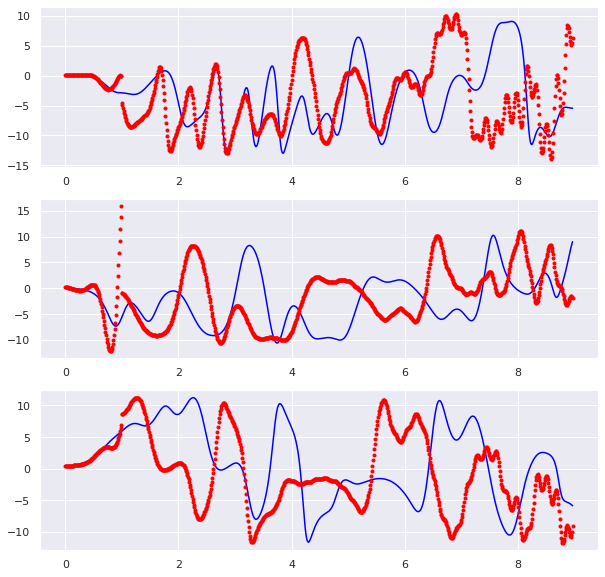

In [20]:
y_train_plot = np.matrix(y_train)
print('y_train_plot shape:',y_train_plot.shape)
Architope_prediction_y_train_plot = np.matrix(Architope_prediction_y_train)
print('Architope_prediction_y_train_plot shape:',Architope_prediction_y_train_plot.shape)
# spatial grid and initial conditions
h = 0.01

tmax = 8.98
step_max = round(tmax/h)
step_plt = int(tmax/(898*h))
dt = h
tt = 0

for step in range(1, step_max):
    t = step*h
    if step % step_plt == 0:
        tt = np.hstack((tt, t))

fig = plt.figure(figsize=(10,10))
N = 3
for i in range(N):
    ax = fig.add_subplot(N,1,1+i)
    row = int(X1.shape[0]/float(N+1))*(i+1)
    print(row)
    print(np.array(y_train_plot[:,row]).shape,Architope_prediction_y_train_plot[:,row].shape)
    ax.plot(tt, np.real(y_train_plot[:,row]), color='blue')
    ax.plot(tt, np.real(Architope_prediction_y_train_plot[:,row]), '.', color='red')


/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


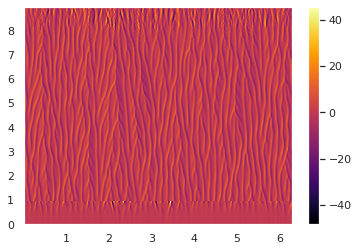

x shape: (898, 2048)
tt shape: (898, 2048)
uu shape: (898, 2048)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.matrix'>


In [21]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

N = 2048
x = (2*np.pi*np.arange(1,N+1)/N)

fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, tt)
uu_mks = np.matrix(Architope_prediction_y_train_plot)
im = ax.pcolormesh(X, T, np.real(uu_mks), cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()
print('x shape:', X.shape)
print('tt shape:', T.shape)
print('uu shape:', uu_mks.shape)
print(type(X), type(T), type(uu_mks))

/home/lenci/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


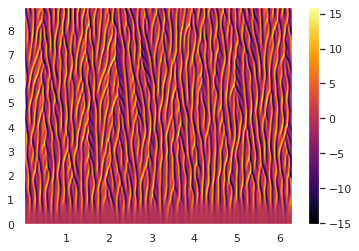

In [22]:
fig, ax = plt.subplots(1,1)
uu_ks = np.matrix(y_train_plot)
im = ax.pcolormesh(X, T, np.real(uu_ks), cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

#### Write Predictions

Compute Performance

In [23]:
#y_test_in = y_test[:,jj]
#print(y_test[:,jj].shape,y_test_in.shape)

In [24]:
# Compute Peformance
print('y_train shape:',y_train.shape)
print('Architope_prediction_y_train shape:', Architope_prediction_y_train.shape)
print('y_test shape:',y_test.shape)
print('Architope_prediction_y_test shape:', Architope_prediction_y_test.shape)
#print('np.sum(Architope_prediction_y_train, axis=1).shape:',np.sum(Architope_prediction_y_train, axis=1).shape)
#performance_Architope_C = np.zeros((3,3))
for jj in range(y_train.shape[1]):
    Training_performance,Test_performance = reporter_high_dim(y_train_hat_in=np.real(Architope_prediction_y_train[:,jj]),
                                    y_test_hat_in=np.real(Architope_prediction_y_test[:,jj]),
                                    y_train_in=np.real(y_train[:,jj]),
                                    y_test_in=np.real(y_test[:,jj]))
    if jj==0:
        Training_perf = Training_performance
        Test_perf = Test_performance
    else:
        Training_perf = np.dstack([Training_perf,Training_performance])
        Test_perf = np.dstack([Test_perf,Test_performance])
#
Training_performance = np.array(np.mean(Training_perf, axis=2)).T
Test_performance = np.array(np.mean(Test_perf, axis=2)).T
#print('Training_performance:',Training_performance)
#print('Test_performance:',Test_performance)
# Organize into Dataframe
#Performance_dataframe = pd.DataFrame({'train': Training_performance,'test': Test_performance})
#Performance_dataframe.index = ["MAE","MSE","MAPE","SMAPE"]
Performance_dataframe_train = pd.DataFrame(Training_performance)
Performance_dataframe_train.index = ["MAE","MSE","MAPE","SMAPE"]
Performance_dataframe_test = pd.DataFrame(Test_performance)
Performance_dataframe_test.index = ["MAE","MSE","MAPE","SMAPE"]
# Update User
#print('dimension:',jj,performance_Architope)
print('Training_performance:',Performance_dataframe_train)
print('Test_performance:',Performance_dataframe_test)
#print('performance_Architope:',performance_Architope)
#performance_Architope = np.sum(performance_Architope_C, axis=1)
# Write Performance
#performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))
Performance_dataframe_train.to_latex((results_tables_path+"Architopes_full_performance_training.tex"))
Performance_dataframe_test.to_latex((results_tables_path+"Architopes_full_performance_test.tex"))


y_train shape: (898, 2048)
Architope_prediction_y_train shape: (898, 2048)
y_test shape: (100, 2048)
Architope_prediction_y_test shape: (100, 2048)
Training_performance:                 0
MAE      6.253663
MSE     65.164590
MAPE   990.046981
SMAPE  133.513676
Test_performance:                 0
MAE      9.136372
MSE    225.726650
MAPE   460.703896
SMAPE  122.080534


## Notes for the user update reported above
- dimension 0 corrispond to the x dimension
- dimension 1 corrispond to the y dimension
- dimension 2 corrispond to the z dimension

---

---

---

## Save data

In [25]:
import pandas as pd

print(Architope_prediction_y_train.shape)
print(Architope_prediction_y_test.shape)
Xdot_KuraSiva_outputPCNN_dataframe = pd.DataFrame(np.real(Architope_prediction_y_train))
Xdot_KuraSiva_outputPCNN_dataframe.index.names = ['index']
Xdot_KuraSiva_outputPCNN_dataframe.to_csv('KuraSiva_PCNN_train.csv')
np.savetxt("KuraSiva_PCNN_train.csv", Xdot_KuraSiva_outputPCNN_dataframe, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)

#########################################################
Xdot_KuraSiva_outputPCNN_dataframe_test = pd.DataFrame(np.real(Architope_prediction_y_test))
Xdot_KuraSiva_outputPCNN_dataframe_test.index.names = ['index']
Xdot_KuraSiva_outputPCNN_dataframe_test.to_csv('KuraSiva_PCNN_test.csv')
np.savetxt("KuraSiva_PCNN_test.csv", Xdot_KuraSiva_outputPCNN_dataframe_test, delimiter=",")
#lorenz_data = pd.read_csv("lorenz_PCNN.csv", header=None)
#lorenz_data.to_csv("lorenz_data.csv", header=["x", "y", "z"], index=False)

#########################################################
Xdot_KuraSiva_outputPCNN_dataframe_long_predM1 = pd.DataFrame(np.real(predictions_long_pred[:,:,0]))
Xdot_KuraSiva_outputPCNN_dataframe_long_predM1.index.names = ['index']
Xdot_KuraSiva_outputPCNN_dataframe_long_predM1.to_csv('KuraSiva_PCNN_long_pred_manifold1.csv')
np.savetxt("KuraSiva_PCNN_long_pred_manifold1.csv", Xdot_KuraSiva_outputPCNN_dataframe_long_predM1, delimiter=",")

#########################################################
Xdot_KuraSiva_outputPCNN_dataframe_long_predM2 = pd.DataFrame(np.real(predictions_long_pred[:,:,1]))
Xdot_KuraSiva_outputPCNN_dataframe_long_predM2.index.names = ['index']
Xdot_KuraSiva_outputPCNN_dataframe_long_predM2.to_csv('KuraSiva_PCNN_long_pred_manifold2.csv')
np.savetxt("KuraSiva_PCNN_long_pred_manifold2.csv", Xdot_KuraSiva_outputPCNN_dataframe_long_predM2, delimiter=",")

#########################################################
KuraSiva_omegaM1 = pd.DataFrame(np.real(omega_manifold1))
KuraSiva_omegaM1.index.names = ['index']
KuraSiva_omegaM1.to_csv('KuraSiva_omega_manifold1.csv')
np.savetxt("KuraSiva_omega_manifold1.csv", KuraSiva_omegaM1, delimiter=",")

#########################################################
KuraSiva_omegaM2 = pd.DataFrame(np.real(omega_manifold2))
KuraSiva_omegaM2.index.names = ['index']
KuraSiva_omegaM2.to_csv('KuraSiva_omega_manifold2.csv')
np.savetxt("KuraSiva_omega_manifold2.csv", KuraSiva_omegaM2, delimiter=",")

#########################################################
KuraSiva_lambdaM1 = pd.DataFrame(np.real(lambda_manifold1))
KuraSiva_lambdaM1.index.names = ['index']
KuraSiva_lambdaM1.to_csv('KuraSiva_lambda_manifold1.csv')
np.savetxt("KuraSiva_lambda_manifold1.csv", KuraSiva_lambdaM1, delimiter=",")

#########################################################
KuraSiva_lambdaM2 = pd.DataFrame(np.real(lambda_manifold2))
KuraSiva_lambdaM2.index.names = ['index']
KuraSiva_lambdaM2.to_csv('KuraSiva_lambda_manifold2.csv')
np.savetxt("KuraSiva_lambda_manifold2.csv", KuraSiva_lambdaM2, delimiter=",")

#########################################################
KuraSiva_phiM1 = pd.DataFrame(np.real(Phi_manifold1))
KuraSiva_phiM1.index.names = ['index']
KuraSiva_phiM1.to_csv('KuraSiva_eigenmodes_manifold1.csv')
np.savetxt("KuraSiva_eigenmodes_manifold1.csv", KuraSiva_phiM1, delimiter=",")

#########################################################
KuraSiva_phiM2 = pd.DataFrame(np.real(Phi_manifold2))
KuraSiva_phiM2.index.names = ['index']
KuraSiva_phiM2.to_csv('KuraSiva_eigenmodes_manifold2.csv')
np.savetxt("KuraSiva_eigenmodes_manifold2.csv", KuraSiva_phiM2, delimiter=",")
 
# print dataframes.
Xdot_KuraSiva_outputPCNN_dataframe
#########################################################
############## -- save data manifold -- #################
#########################################################
print('Architope_manifolds_prediction_y_train',Architope_manifolds_prediction_y_train.shape)
print('Architope_manifolds_prediction_y_test',Architope_manifolds_prediction_y_test.shape)
################ --- manifold 1 train --- #####################
Architope_manifold1_prediction_y_train = pd.DataFrame(np.real(Architope_manifolds_prediction_y_train[:,:,0]))
Architope_manifold1_prediction_y_train.index.names = ['index']
Architope_manifold1_prediction_y_train.to_csv('KuraSiva_PCNN_manifold1.csv')
np.savetxt("KuraSiva_PCNN_manifold1.csv", Architope_manifold1_prediction_y_train, delimiter=",")
################ --- manifold 2 train --- #####################
Architope_manifold2_prediction_y_train = pd.DataFrame(np.real(Architope_manifolds_prediction_y_train[:,:,1]))
Architope_manifold2_prediction_y_train.index.names = ['index']
Architope_manifold2_prediction_y_train.to_csv('KuraSiva_PCNN_manifold2.csv')
np.savetxt("KuraSiva_PCNN_manifold2.csv", Architope_manifold2_prediction_y_train, delimiter=",")
################ --- manifold 3 train --- #####################
#Architope_manifold3_prediction_y_train = pd.DataFrame(Architope_manifolds_prediction_y_train[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_train.index.names = ['index']
#Architope_manifold3_prediction_y_train.to_csv('lorenz_PCNN_manifold3.csv')
#np.savetxt("lorenz_PCNN_manifold3.csv", Architope_manifold3_prediction_y_train, delimiter=",")

################ --- manifold 1 test --- #####################
Architope_manifold1_prediction_y_test = pd.DataFrame(np.real(Architope_manifolds_prediction_y_test[:,:,0]))
Architope_manifold1_prediction_y_test.index.names = ['index']
Architope_manifold1_prediction_y_test.to_csv('KuraSiva_PCNN_manifold1_test.csv')
np.savetxt("KuraSiva_PCNN_manifold1_test.csv", Architope_manifold1_prediction_y_test, delimiter=",")
################ --- manifold 2 test --- #####################
Architope_manifold2_prediction_y_test = pd.DataFrame(np.real(Architope_manifolds_prediction_y_test[:,:,1]))
Architope_manifold2_prediction_y_test.index.names = ['index']
Architope_manifold2_prediction_y_test.to_csv('KuraSiva_PCNN_manifold2_test.csv')
np.savetxt("KuraSiva_PCNN_manifold2_test.csv", Architope_manifold2_prediction_y_test, delimiter=",")
################ --- manifold 3 test --- #####################
#Architope_manifold3_prediction_y_test = pd.DataFrame(Architope_manifolds_prediction_y_test[:,:,2], columns=['xdot', 'ydot', 'zdot'])
#Architope_manifold3_prediction_y_test.index.names = ['index']
#Architope_manifold3_prediction_y_test.to_csv('lorenz_PCNN_manifold3_test.csv')
#np.savetxt("lorenz_PCNN_manifold3_test.csv", Architope_manifold3_prediction_y_test, delimiter=",")


(898, 2048)
(100, 2048)
Architope_manifolds_prediction_y_train (898, 2048, 2)
Architope_manifolds_prediction_y_test (100, 2048, 2)


### Model Complexity/Efficiency Metrics

In [26]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
Efficiency = np.round(Efficiency,3)


# Build Table #
#-------------#
Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


# Write Required Training Time(s)
Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Architope_Model_Complexity_full)

NameError: name 'performance_Architope' is not defined

---
---
# Benchmark(s)
---
---

### Architope with Logistic-Classifier Partitioning
#### Train Logistic Classifier (Benchmark)

In [ ]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training_begin = time.time()

In [ ]:
parameters = {'penalty': ['none','l2'], 'C': [0.1, 0.5, 1.0, 10, 100, 1000]}
lr = LogisticRegression(random_state=2020)
cv = RepeatedStratifiedKFold(n_splits=CV_folds, n_repeats=n_iter, random_state=0)
classifier = RandomizedSearchCV(lr, parameters, random_state=2020)

# Initialize Classes Labels
partition_labels_training = np.argmin(training_quality,axis=-1)

#### Train Logistic Classifier

In [ ]:
# Update User on shape of learned partition
print(partition_labels_training)

In [ ]:
# Update User #
#-------------#
print("Training classifier and generating partition!")

# Train Logistic Classifier #
#---------------------------#
# Supress warnings caused by "ignoring C" for 'none' penalty and similar obvious warnings
warnings.simplefilter("ignore")
# Train Classifier
classifier.fit(X_train, partition_labels_training)

#### Write Predicted Class(es)

In [ ]:
# Training Set
predicted_classes_train_logistic_BM = classifier.best_estimator_.predict(X_train)
Architope_prediction_y_train_logistic_BM = np.take_along_axis(predictions_train, predicted_classes_train_logistic_BM[:,None], axis=1)

# Testing Set
predicted_classes_test_logistic_BM = classifier.best_estimator_.predict(X_test)
Architope_prediction_y_test_logistic_BM = np.take_along_axis(predictions_test, predicted_classes_test_logistic_BM[:,None], axis=1)

# Extract Number of Parameters Logistic Regressor
N_params_best_logistic = (classifier.best_estimator_.coef_.shape[0])*(classifier.best_estimator_.coef_.shape[1]) + len(classifier.best_estimator_.intercept_)

In [ ]:
# Time-Elapsed Training linear classifier
Architope_logistic_classifier_training = time.time() - Architope_logistic_classifier_training_begin

#### Compute Performance

In [ ]:
# Compute Peformance
performance_architope_ffNN_logistic = reporter(y_train_hat_in=Architope_prediction_y_train_logistic_BM,
                                    y_test_hat_in=Architope_prediction_y_test_logistic_BM,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_architope_ffNN_logistic.to_latex((results_tables_path+"Architopes_logistic_performance.tex"))

# Update User
print(performance_architope_ffNN_logistic)

---
## Bagged Feed-Forward Networks (ffNNs)

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time_begin = time.time()

In [ ]:
# Train Bagging Weights in-sample
bagging_coefficients = LinearRegression().fit(predictions_train,y_train)

# Predict Bagging Weights out-of-sample
bagged_prediction_train = bagging_coefficients.predict(predictions_train)
bagged_prediction_test = bagging_coefficients.predict(predictions_test)

# Write number of trainable bagging parameters
N_bagged_parameters = len(bagging_coefficients.coef_) + 1

In [ ]:
# Time for Bagging
Bagging_ffNN_bagging_time = time.time() - Bagging_ffNN_bagging_time_begin

In [ ]:
# Compute Peformance
performance_bagged_ffNN = reporter(y_train_hat_in=bagged_prediction_train,
                                    y_test_hat_in=bagged_prediction_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
# Write Performance
performance_bagged_ffNN.to_latex((results_tables_path+"ffNN_Bagged.tex"))

# Update User
print("Written Bagged Performance")
print(performance_bagged_ffNN)

In [ ]:
print("Random Partition: Generated!...Feature Generation Complete!")

## Vanilla ffNN
#### Reload Hyper-parameter Grid

In [ ]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Update Dimensions
param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]

In [ ]:
# Time for Bagging
Vanilla_ffNN_time_beginn = time.time()

In [ ]:
#X_train vanilla ffNNs
y_hat_train_Vanilla_ffNN, y_hat_test_Vanilla_ffNN, N_params_Vanilla_ffNN = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                      n_jobs = n_jobs, 
                                                                                      n_iter = n_iter, 
                                                                                      param_grid_in = param_grid_Vanilla_Nets, 
                                                                                      X_train=X_train, 
                                                                                      y_train=data_y, 
                                                                                      X_test_partial=X_train,
                                                                                      X_test=X_test,
                                                                                      NOCV=True)

In [ ]:
# Time for Bagging
Vanilla_ffNN_time = time.time() - Vanilla_ffNN_time_beginn

In [ ]:
# Update User #
#-------------#
print("Trained vanilla ffNNs")

#### Evaluate Performance

In [ ]:
# Compute Peformance
performance_Vanilla_ffNN = reporter(y_train_hat_in=y_hat_train_Vanilla_ffNN,y_test_hat_in=y_hat_test_Vanilla_ffNN,y_train_in=y_train,y_test_in=y_test)
# Write Performance
performance_Vanilla_ffNN.to_latex((results_tables_path+"ffNN_Vanilla.tex"))

# Update User #
#-------------#
print("Written Bagged Vanilla ffNNs")
print(performance_Vanilla_ffNN)

#### Compute Required Training Time(s)

In [ ]:
# In-Line #
#---------#

# Architope (Full) Time Lapse
Architope_Full_Time = partitioning_time + Architope_partition_training + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time = partitioning_time + Architope_partition_training + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time = partitioning_time + Architope_partition_training + Bagging_ffNN_bagging_time
# Vanilla ffNN
Vanilla_ffNN_Time = Vanilla_ffNN_time

# Parallel (Only if applicable) #
#-------------------------------#

# Architope (Full) Time Lapse
Architope_Full_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_deep_classifier_training
# Architope (Logistic) Time Lapse
Architope_logistic_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Architope_logistic_classifier_training
# Bagged ffNN Training Time
Bagged_ffNN_Time_parallel = partitioning_time + Architope_partitioning_max_time_running + Bagging_ffNN_bagging_time

#### Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Writing preliminary table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Architope': [round(Architope_Full_Time,3)],
                                'Architope-logistic': [round(Architope_logistic_Time,3)],
                                'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                'Bagged ffNN': [round(Bagged_ffNN_Time,3)]})
training_times_Parallel = pd.DataFrame({'Architope': [round(Architope_Full_Time_parallel,3)],
                                'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                'Vanilla ffNN': ['-'],
                                'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)]})

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

## Run: Gradient Boosted Random Forest Regression

In [ ]:
# Update User #
#-------------#
print('Training Gradient-Boosted Random Forest: In-progress...')
# Run from External Script
exec(open('Gradient_Boosted_Random_Forest_Regressor.py').read())

# Update User #
#-------------#
print('Training of Gradient-Boosted Random Forest: Complete!')

## Training Result(s)
#### (Update) Write Required Training Times

In [ ]:
# Update User #
#-------------#
print('Completing Table: Required Training Times')

# Format Required Training Time(s)
training_times_In_Line = pd.DataFrame({'Vanilla ffNN': [round(Vanilla_ffNN_Time,3)],
                                       'Grad.Bstd Rand.F': [round(Gradient_boosted_Random_forest_time,3)],
                                       'Bagged ffNN': [round(Bagged_ffNN_Time,3)],
                                       'Architope-logistic': [round(Architope_logistic_Time,3)],
                                       'Architope': [round(Architope_Full_Time,3)]
                                      },index=['In-Line (L-Time)'])

training_times_Parallel = pd.DataFrame({'Vanilla ffNN': ['-'],
                                        'Grad.Bstd Rand.F': ['-'],
                                        'Bagged ffNN': [round(Bagged_ffNN_Time_parallel,3)],
                                        'Architope-logistic': [round(Architope_logistic_Time_parallel,3)],
                                        'Architope': [round(Architope_Full_Time_parallel,3)]},index=['Parallel (P-Time)'])

# Combine Training Times into Single Data-Frame #
#-----------------------------------------------#
Model_Training_times = training_times_In_Line.append(training_times_Parallel)
Model_Training_times = Model_Training_times.transpose()

# Write Required Training Time(s)
Model_Training_times.to_latex((results_tables_path+"Model_Training_Times.tex"))
# Display Required Training Time(s)
print(Model_Training_times)

### Prediction Metric(s)
#### Write Predictive Performance Dataframe(s)

In [ ]:
# Write Training Performance
predictive_performance_training = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.train,
                                                'GBRF': Gradient_boosted_tree.train,
                                                'ffNN-bag': performance_bagged_ffNN.train,
                                                'ffNN-lgt': performance_architope_ffNN_logistic.train,
                                                'tope': performance_Architope.train})
predictive_performance_training = predictive_performance_training.transpose()

# Write Testing Performance
predictive_performance_test = pd.DataFrame({'ffNN': performance_Vanilla_ffNN.test,
                                            'GBRF': Gradient_boosted_tree.test,
                                            'ffNN-bag': performance_bagged_ffNN.test,
                                            'ffNN-lgt': performance_architope_ffNN_logistic.test,
                                            'tope': performance_Architope.test})
predictive_performance_test = predictive_performance_test.transpose()

# Write into one Dataframe #
#--------------------------#
predictive_performance_training.to_latex((results_tables_path+"Models_predictive_performance_training.tex"))
predictive_performance_test.to_latex((results_tables_path+"Models_predictive_performance_testing.tex"))

# Update User #
#-------------#
print(predictive_performance_training)

### Model Complexity/Efficiency Metrics

In [ ]:
# Compute Parameters for composite models #
#-----------------------------------------#
N_params_Architope_full = N_params_Architope + N_params_deep_classifier
N_params_Architope_logistic = N_params_Architope + N_params_best_logistic
N_params_bagged_ffNN = N_params_Architope + N_bagged_parameters

# Build Table #
#-------------#
Number_of_model_parameters = pd.DataFrame({'Vanilla ffNN': [N_params_Vanilla_ffNN],
                                           'Grad.Bstd Rand.F': [N_tot_params_in_forest],
                                           'Bagged ffNN': [N_params_bagged_ffNN],
                                           'Architope-logistic': [N_params_Architope_logistic],
                                           'Architope': [N_params_Architope_full]},
                                            index=['N_par'])

Number_of_model_parameters = Number_of_model_parameters.transpose()

# Append to Dataframe #
#---------------------#
Model_Complexity_Metrics = Model_Training_times
Model_Complexity_Metrics['N_par']=Number_of_model_parameters.values

# Build AIC-like Metric #
#-----------------------#
AIC_like = 2*((Model_Complexity_Metrics.N_par.values) - np.log(predictive_performance_test.MAE.values))
AIC_like = np.round(AIC_like,3)
Efficiency = np.log(Model_Complexity_Metrics.N_par.values) *predictive_performance_test.MAE.values
Efficiency = np.round(Efficiency,3)


# Update Training Metrics Dataframe #
#-----------------------------------#
Model_Complexity_Metrics['AIC_like'] = AIC_like
Model_Complexity_Metrics['Eff'] = Efficiency

# Write Required Training Time(s)
Model_Complexity_Metrics.to_latex((results_tables_path+"Model_Complexity_Metrics.tex"))

#--------------======---------------#
# Display Required Training Time(s) #
#--------------======---------------#
print(Model_Complexity_Metrics)

# Summary

In [ ]:
print(' ')
print(' ')
print('#-------------------#')
print(' PERFORMANCE SUMMARY:')
print('#-------------------#')
print(' ')
print(' ')
print('#===================#')
print(' Individual Metrics: ')
print('#======-============#')
print(' ')
print('----------------------------------------')
print('----------------------------------------')
print('Architope (Full)')
print('----------------------------------------')
print(performance_Architope)
print('----------------------------------------')
print('Architope - Naive Logistic')
print('----------------------------------------')
print(performance_architope_ffNN_logistic)
print('----------------------------------------')
print('Vanilla ffNN')
print('----------------------------------------')
print(performance_Vanilla_ffNN)
print('----------------------------------------')
print('Bagged ffNN')
print('----------------------------------------')
print(performance_bagged_ffNN)
print('----------------------------------------')
print('Gradient Boosted Random Forest Regressor')
print('----------------------------------------')
print(Gradient_boosted_tree)
print('----------------------------------------')
print('----------------------------------------')
print(' ')
print(' ')
#
print('#==================#')
print(' Overview  Metrics : ')
print('#==================#')
print(' ')
print('----------------------------------------')
print('Training Performance: ')
print('----------------------------------------')
print(predictive_performance_training)
print('----------------------------------------')
print('Testing Performance: ')
print('----------------------------------------')
print(predictive_performance_test)
print('----------------------------------------')
print(' ')
print(' ')
#
print('#====================#')
print(' Efficiency Metrics: ')
print('#====================#')
print(' ')
print('Model Training Times:')
print('----------------------------------------')
print(Model_Complexity_Metrics)
print(' ')
print(' ')
print('😃😃 Have a great day!! 😃😃 ')

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
plt.scatter(x_1,y_1,color='slategrey',label=r'$f_1(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)
plt.scatter(x_2,y_2,color='dodgerblue',label=r'$f_2(x)$',linestyle=(0,(1,1)),s=3,alpha=.9,marker=1)

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)
#
#jj = 0
#for j in range(0,len(x)-1,10):
#    jj = jj+1;
#    plt.scatter(x[j],y_hat_train_Vanilla_ffNN[jj], color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
#    plt.scatter(x[j],Architope_prediction_y_train[jj], color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/DEMO.pdf', format='pdf')

In [ ]:
#import numpy as np
#print(len(x)-1,len(y_hat_train_Vanilla_ffNN))
#print(np.linspace(10,len(x)-1,len(y_hat_train_Vanilla_ffNN)))
#def my_func(low,up,leng):
#    list = []
#    step = int((up - low) / float(leng))
#    print(step)
#    for i in range(leng):
#        list.append(int(low))
#        low = int(low + step)
#    return list
#
#my_list = my_func(0,len(x)-1,len(y_hat_train_Vanilla_ffNN))
#res = [int(item) for item in my_list]
#
#print(my_list)
#print(type(my_list))
#
#indice_prova = 10,len(x)-1,len(y_hat_train_Vanilla_ffNN);
#for j in range(0,len(x)-1,10):
#    print(j,np.matrix(x[j]).shape)
    

---
# Fin
---

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#
# Plot Signal
# plt.scatter(x,y,color='gray',label='$f(x)$',linestyle='--')
dfX_train = pd.DataFrame(X_train,columns=['x','y','z'])
dfX_train.plot(x = 'x', y='y', z='z', kind = 'scatter')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.scatter(x,y_hat_train_Vanilla_ffNN, color = 'darkmagenta',linestyle=(0,(1,10)),  label='ffNN',s=3,alpha=.95)
plt.scatter(x,Architope_prediction_y_train, color = 'mediumseagreen',linestyle=(0,(1,10)), label='tope',s=3,alpha=.95)



# Format Plot #
#-------------#
plt.legend(loc="upper left",prop={'size': 10})
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/lorenz.pdf', format='pdf')